In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt

In [2]:
infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root'
#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root"

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
year='2018'

doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}

singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',   # Recomended
        ]
}

In [5]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

In [6]:
# -- Helper function: Flat dimension and pop NaN
def flat_dim(arr):

    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])

In [7]:
# -- Helper function: Sort paricles by PT-order
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet

In [8]:
# Sort particle order by PT
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

In [9]:
Initial_events = events
print("#### Initial events: ",len(Initial_events))
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]
print("#### Passing Trigger: ",len(events))

#### Initial events:  58612
#### Passing Trigger:  50077


### 1. Particle Selection

In [10]:
Electron = events.Electron
Photon   = events.Photon
Jet      = events.Jet

In [11]:
def Particle_selection(ele,pho,jet):
    # Electron selection
    EleSelmask = (ele.pt > 25) & (np.abs(ele.eta) < 2.5) & (ele.cutBased > 2)

    # Photon selection
    # 0 Fail 1 Loose 2 Medium 3 Tight
    # -- HoE cut is added manually
    #PhoSelmaskEE = (pho.pt > 25) & (pho.cutBased > 1) &  pho.isScEtaEE & (pho.hoe < 0.0326)
    #PhoSelmaskEB = (pho.pt > 25) & (pho.cutBased > 1) &  pho.isScEtaEB & (pho.hoe < 0.02197)
    #PhoSelmask = PhoSelmaskEE | PhoSelmaskEB
    
    # -- Original Photon selection
    PhoSelmask = (pho.pt > 25) & (pho.cutBased > 1)
    
    # -- Jet selection for dR cut -- #
    bJet_selmask = (jet.btagCMVA > -0.5844)
    #JetSelmask = (jet.btagCMVA > -999)
    
    
    return EleSelmask,PhoSelmask,bJet_selmask

In [12]:
# Event Selection
Electron_mask, Photon_mask, bjet_selmask  = Particle_selection(Electron,Photon,Jet)

Ele_channel_mask = ak.num(Electron[Electron_mask])  > 1
#Ele_channel_mask = ak.num(Electron[Electron_mask]) == 3

Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0

bJet_veto_mask = ak.num(Jet[bjet_selmask]) == 0


Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask &  bJet_veto_mask]

In [13]:
print("Events: {0} --> {1} ".format(len(events), len(Ele_channel_events)))

Events: 50077 --> 24816 


### 2. Make Paricle array from selected events

In [14]:
Electron = Ele_channel_events.Electron
Photon = Ele_channel_events.Photon
Jet = Ele_channel_events.Jet

In [15]:
Electron_mask,Photon_mask,_ = Particle_selection(Electron,Photon,Jet)
Electron = Electron[Electron_mask]
Photon = Photon[Photon_mask]
Jet = Jet

### 3. Select Electron pair 

In [ ]:
#def make_ele_triplet: ...

In [16]:
def make_ele_pairs(ele):
    leading_ele = ele[:,0]
    subleading_ele = ele[:,1]
    
    return leading_ele, subleading_ele

### 4. Select Photon with dR < 0.4

In [22]:
leading_ele, subleading_ele = make_ele_pairs(Electron)

def make_DR(ele1,ele2,pho,jet):
      
    dR_e1pho  = ele1.delta_r(pho)
    dR_e2pho  = ele2.delta_r(pho)
    dR_phojet = jet[:,0].delta_r(pho)
    dR_mask   = (dR_e1pho > 0.4) & (dR_e2pho > 0.4) & (dR_phojet > 0.4)
    
    return dR_mask,dR_e1pho,dR_e2pho,dR_phojet

In [23]:
dR_mask,dR_e1pho,dR_e2pho,dR_phojet = make_DR(leading_ele,subleading_ele,Photon,Jet)

In [24]:
print(ak.num(Photon))
print(ak.num(dR_mask))

[2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2]
[2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2]


(0.0, 1.0)

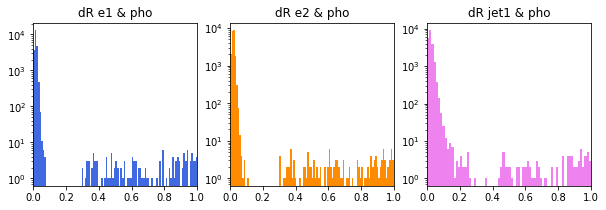

In [25]:
bins=500
fig,axs = plt.subplots(1,3,figsize=(10,3))
axs[0].hist(flat_dim(dR_e1pho),bins=bins,color='royalblue')
axs[0].set_title('dR e1 & pho')
axs[0].set_yscale('log')
axs[0].set_xlim(0,1)

axs[1].hist(flat_dim(dR_e2pho),bins=bins,color='darkorange')
axs[1].set_title('dR e2 & pho')
axs[1].set_yscale('log')
axs[1].set_xlim(0,1)

axs[2].hist(flat_dim(dR_phojet),bins=bins,color='violet')
axs[2].set_title('dR jet1 & pho')
axs[2].set_yscale('log')
axs[2].set_xlim(0,1)

In [26]:
Photon = Photon[dR_mask]

### 5. Event Selection

In [27]:
Ele_channel_with_dR = Ele_channel_events[ak.num(Photon) > 0]
Electron = Ele_channel_with_dR.Electron
Photon   = Ele_channel_with_dR.Photon
Jet      = Ele_channel_with_dR.Jet

In [28]:
print(ak.num(Photon))

[3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, ... 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3]


In [29]:
Electron_mask,Photon_mask,_ = Particle_selection(Electron,Photon,Jet)
Ele_sel = Electron[Electron_mask]
Pho_sel = Photon[Photon_mask]
Jet_sel = Jet

In [30]:
print(ak.num(Photon))

[3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, ... 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3]


In [31]:
leading_ele, subleading_ele = make_ele_pairs(Ele_sel)

In [35]:
dR_mask,dR_e1pho,dR_e2pho,dR_phojet = make_DR(leading_ele,subleading_ele,Pho_sel,Jet_sel)

In [36]:
Pho_sel = Pho_sel[dR_mask]

In [42]:
diele = leading_ele + subleading_ele
zmass_window_mask = (diele.mass) > 60 | (diele.mass < 120)

In [43]:
eeg_vec = diele + Pho_sel[:,0]

In [44]:
Meeg_mask = eeg_vec.mass > 120

In [46]:
Ele_channel_evtSel = Ele_channel_with_dR[zmass_window_mask & Meeg_mask]
print(len(Ele_channel_evtSel))

30


In [48]:
Electron = Ele_channel_evtSel.Electron
Photon = Ele_channel_evtSel.Photon
Jet = Ele_channel_evtSel.Jet

Electron_mask,Photon_mask,_ = Particle_selection(Electron,Photon,Jet)
Ele_sel = Electron[Electron_mask]
Pho_sel = Photon[Photon_mask]
Jet_sel = Jet

leading_ele, subleading_ele = make_ele_pairs(Ele_sel)
dR_mask,dR_e1pho,dR_e2pho,dR_phojet = make_DR(leading_ele,subleading_ele,Pho_sel,Jet_sel)
Pho_sel = Pho_sel[dR_mask]